# Prepare
1. Please unzip the content in data.zip to a folder named 'data' under root folder
2. Then run the code blocks sequentially

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import keras
from keras.models import Model, load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from dataloader import trainGenerator, validGenerator
from model_9_layer_GSLRE import build_model_GSLRE
from visualize import layer_predict, display_channel_images, plotting_curves, compare_curves, binarify_sample
from training import training_loop, evaluation
from keras.utils.vis_utils import plot_model

In [2]:
rootDir='./data/image_data'
trainDir = os.path.join(rootDir, 'train')
validDir = os.path.join(rootDir, 'test')
with open('./data/char_dict', 'rb') as handler:
    charDict = pkl.load(handler)
    
with open('./data/index_key_500.pickle', 'rb') as handler:
    index_key_500 = pkl.load(handler)

classSize = 500
batchSize = 128
val_batchSize = 128
width, height = 96, 96

# Data Loading

In [3]:
vg_origin = validGenerator(validDir, val_batchSize, 96, 96)
vg_binary = validGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.
Found 29894 images belonging to 500 classes.


In [4]:
tg_origin = trainGenerator(trainDir, batchSize, 96, 96)
tg_binary = trainGenerator(trainDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 119702 images belonging to 500 classes.
Found 119702 images belonging to 500 classes.


Data visualize and a sample of binarify


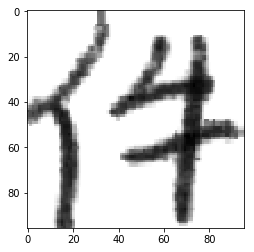

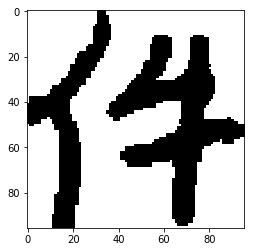

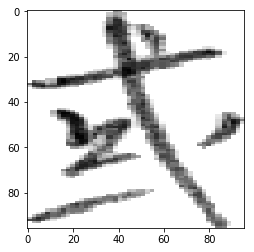

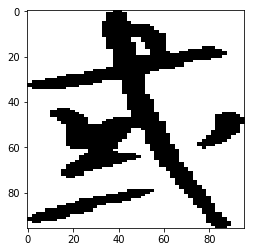

In [9]:
print('Data visualize and a sample of binarify')
tg_sample = tg_origin[0][0][0]
vg_sample = vg_origin[0][0][0]
plt.imshow(tg_sample.reshape(width, height), cmap='gray')
plt.show()
plt.imshow(binarify_sample(tg_sample, 0.99), cmap='gray')
plt.show()
plt.imshow(vg_sample.reshape(width, height), cmap='gray')
plt.show()
plt.imshow(binarify_sample(vg_sample, 0.99), cmap='gray')
plt.show()


# Training 

OR download the weights (50.6MB for each model) from: <br>
Model A trained with original images: <br>
https://drive.google.com/open?id=14gVqHhUaMtOhANS4EpymiUnhaNExPxG2
<br> Model B trained with binary images (threshold 0.99): <br>
https://drive.google.com/open?id=1TQGx8wGSg7GSXHqxAd-VpRHKMBFlVeTa
<br> And the our pickle files for histroy of training are provided on markus repo 

In [16]:
modelA = build_model_GSLRE(classSize)
modelB = build_model_GSLRE(classSize)

In [ ]:
#Model A training 
training_loop(modelA, tg_origin, vg_origin, 
              'model_origin_weights_best_epoch.hdf5', 
              'history_epoch_origin.pickle', epoch=50)
#The function will train the model with epoches in tens. 
#For example, if epoch=50 it train model 10 epoches 5 times

In [ ]:
#Model B training 
training_loop(modelB, tg_binary, vg_binary, 
              'model_b0.99_weights_best_epoch.hdf5', 
              'history_epoch_b0.99.pickle', epoch=50)
#The function will train the model with epoches in tens. 
#For example, if epoch=50 it train model 10 epoches 5 times

In [11]:
test_model = build_model_GSLRE(500)

test_model.load_weights('model_origin_weights_best_epoch.hdf5')
test_model.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

test_loss, test_acc = test_model.evaluate_generator(ovg, verbose=1)



234/234 [==============================] - 433s 2s/step


[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]
候
原
便
集
接
受
属
展


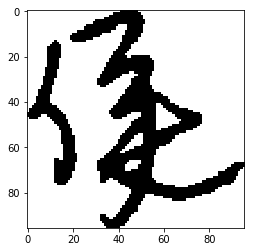

In [17]:
# test_model.compile(loss='categorical_crossentropy',
#         optimizer='SGD',
#         metrics=['accuracy'])

# test_loss, test_acc = test_model.evaluate_generator(vg, verbose=1)
sample = vg[7][0][0].reshape(1, 96, 96, 1)

print(sample[0])

result = test_model.predict(sample, batch_size=1).reshape(classSize)
# number of output
index = result.argsort()[-8:][::-1]
# dont need this one when in gui
plt.imshow(sample.reshape(96,96), cmap='gray')
# 
for i in index:
    print(index_key_500[i])

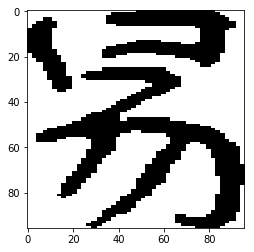

In [24]:

temp = vg[85][0][0]
# temp = (temp - temp.min())/ np.ptp(temp)
# print(temp.min())
# plt.imshow(temp.reshape(96,96), cmap='gray')
plt.imshow(temp.reshape(96,96)[:,:], cmap='gray')

In [9]:
k=4
b = 0.1**k
b

0.00010000000000000002

In [32]:
freq500Words = np.load('./data/MostFreq500inHWDB1.1.npy')

In [38]:
index_key_500 = {}
for key, value in charDict.items():
    if freq500Words[value] == 1:
        newLabel = np.int(freq500Words[:value+1].sum() - 1)
        index_key_500[newLabel] = key
with open('./data/index_key_500.pickle', 'wb') as handler:
        pkl.dump(index_key_500, handler, protocol=pkl.HIGHEST_PROTOCOL)

In [7]:
test_loss, test_acc

(0.18790950887580615, 0.9523650230177511)

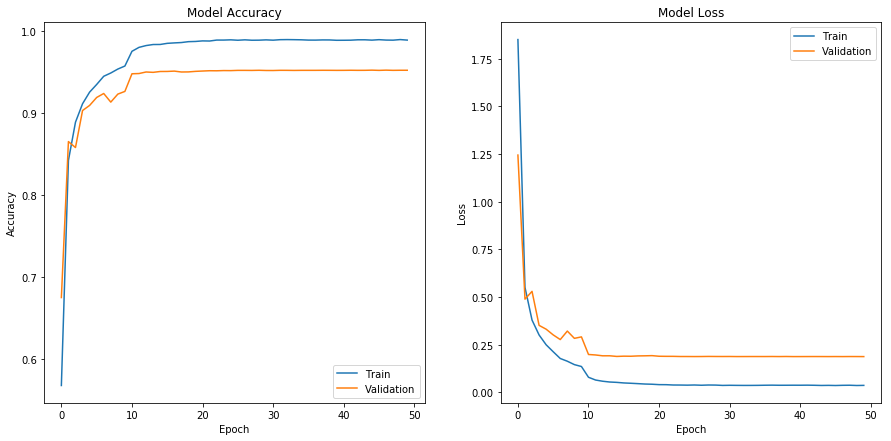

In [2]:
binary_hist = './500_b0.99'
origin_hist = './500_origin'

plotting_curves(os.path.join(binary_hist, 'history_epoch_b0.99.pickle'), 'history_binary_model.png')


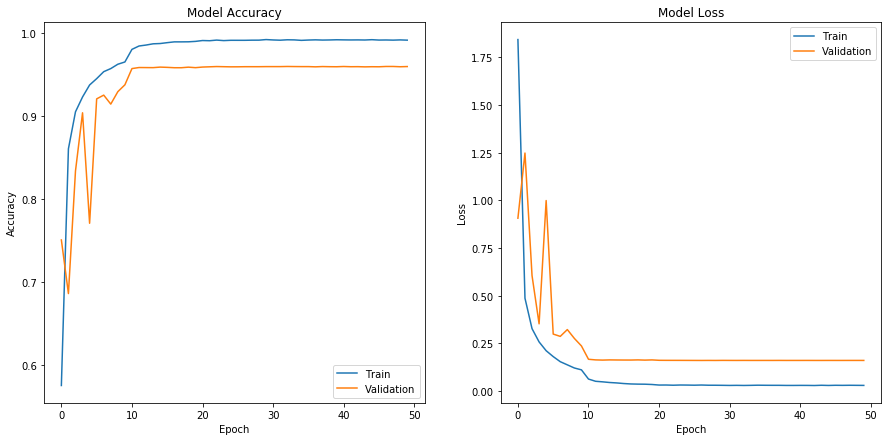

In [3]:

plotting_curves(os.path.join(origin_hist, 'history_epoch_origin.pickle'), 'history_origin_model.png')

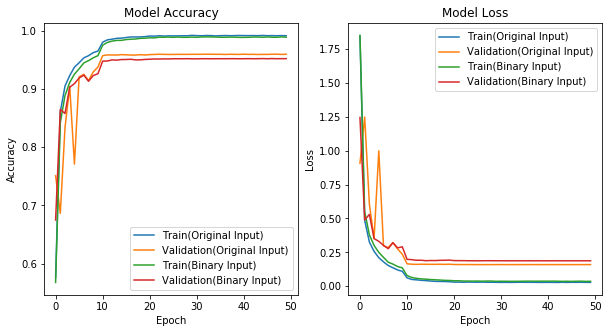

In [4]:
compare_curves(os.path.join(origin_hist, 'history_epoch_origin.pickle'), 
               os.path.join(binary_hist, 'history_epoch_b0.99.pickle'), 
               'history_both_models.png')

In [8]:
binary_model = build_model_GSLRE(500)
origin_model = build_model_GSLRE(500)
binary_model.load_weights('model_b0.99_weights_best_epoch.hdf5')
origin_model.load_weights('model_origin_weights_best_epoch.hdf5')
sample = vg[99][0][0].reshape(1, 96, 96, 1)
sample2 = ovg[99][0][0].reshape(1, 96, 96, 1)

In [12]:
binary_first_layer = display_channel_images(binary_model, 'conv1', sample)
origin_first_layer = display_channel_images(origin_model, 'conv1', sample2)

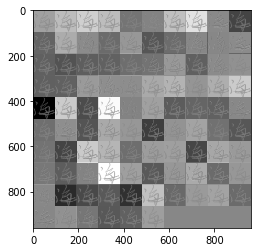

In [13]:
origin_first_layer.shape
plt.imshow(origin_first_layer[0], cmap='gray')


In [89]:
def reshape_channels(layer_output, column_number=11):

    batchSize, height, width, channels = layer_output.shape
    canvas = np.zeros((batchSize, height * ((channels//column_number) + 1), width * column_number))
    for i in range(batchSize):
        for j in range(channels):
            image = layer_output[i, :, :, j].reshape(height, width)
            H_S = (j // column_number) * height
            W_S = (j % column_number) * width
            canvas[i, H_S: (H_S+height), W_S: (W_S+width)] = image

    return canvas

out = reshape_channels(origin_first_layer)

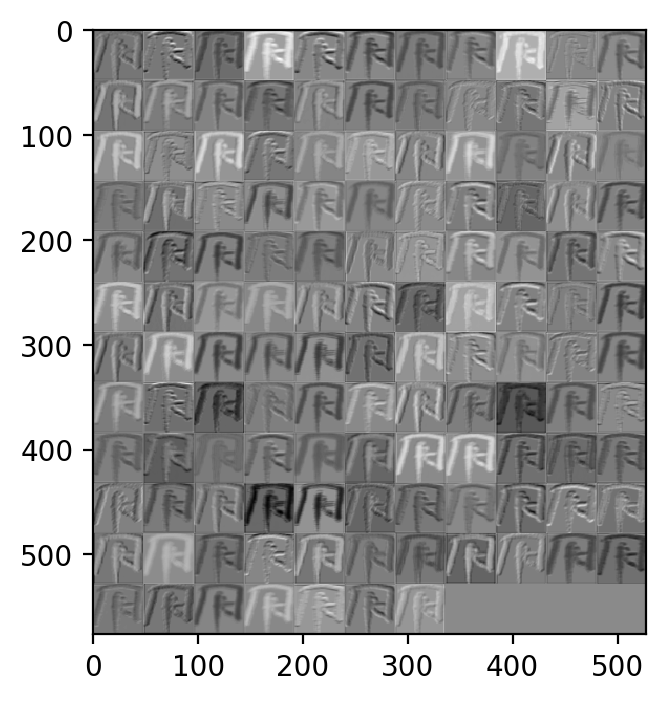

In [90]:
plt.imshow(out[0], cmap='gray')

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, PReLU
def channelD(C, N, W, W_p, K=3, x=4):

    return (C * N * K * W_p) // ((C * W + N * W_p) * x)
def build_model_visual(classSize, x=4):
    model = keras.Sequential()
    model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same', name='conv1',
                                   input_shape=(96, 96, 1)))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))


    D = channelD(96, 128, 48, 48, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv2_de1'))
    model.add(Conv2D(filters=128, kernel_size=(1, 3), padding='same', name='conv2_de2'))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    D = channelD(128, 160, 24, 24, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv3_de1'))
    model.add(Conv2D(filters=160, kernel_size=(1, 3), padding='same', name='conv3_de2'))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    D = channelD(160, 256, 12, 12, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv4_1_de1'))
    model.add(Conv2D(filters=256, kernel_size=(1, 3), padding='same', name='conv4_1_de2'))


    D = channelD(256, 256, 12, 12, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv4_2_de1'))
    model.add(Conv2D(filters=256, kernel_size=(1, 3), padding='same', name='conv4_2_de2'))


    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    D = channelD(256, 384, 6, 6, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv5_1_de1'))
    model.add(Conv2D(filters=384, kernel_size=(1, 3), padding='same', name='conv5_1_de2'))


    D = channelD(384, 384, 6, 6, 3, x)
    model.add(Conv2D(filters=D, kernel_size=(3, 1), padding='same', name='conv5_2_de1'))
    model.add(Conv2D(filters=384, kernel_size=(1, 3), padding='same', name='conv5_2_de2'))

    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(1024, name='fc1'))

    model.add(Dense(classSize, activation='softmax', name='fc2'))

    return model

plot_model(build_model_visual(500), to_file='model_plot_GSLRE.png', show_shapes=True, show_layer_names=True)

In [12]:
test_loss, test_acc

(0.16004430845049844, 0.9598916169830953)